In [71]:
import pandas as pd
df = pd.read_csv('smoking.csv')
df = df[:10000]

In [72]:

from sklearn.utils import resample

#Trova la classe target più rappresentata
classe_target_più_rappresentata = df['smoking'].value_counts().idxmax()

#Suddividi il dataset in due parti in base alla classe target
df_maggioritaria = df[df['smoking'] == classe_target_più_rappresentata]
df_minimizzata = df[df['smoking'] != classe_target_più_rappresentata]

#Riduci il numero di campioni nella classe maggioritaria al numero di campioni nella classe minoritaria
df_maggioritaria_downsampled = resample(df_maggioritaria,
                                        replace=False,  # campioni presi senza sostituzione
                                        n_samples=len(df_minimizzata),  # numero di campioni uguale alla classe minoritaria
                                        random_state=42)  # per riproducibilità

#Unisci i due sottoinsiemi bilanciati
df_filtered = pd.concat([df_maggioritaria_downsampled, df_minimizzata])

#Ora df_bilanciato contiene il tuo dataset bilanciato
#Puoi salvarlo in un nuovo file CSV se necessario
sampled_counts = df_filtered['smoking'].value_counts()
print("\nCounts nel dataset partizionato:\n", sampled_counts)


Counts nel dataset partizionato:
 smoking
0    3616
1    3616
Name: count, dtype: int64


In [73]:
df_filtered = df_filtered.drop(['ID', 'height(cm)', 'oral'], axis=1)
df_filtered['tartar'] = df_filtered['tartar'].apply(lambda x: 1 if x == 'Y' else 0)
df_filtered['gender'] = df_filtered['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [74]:

variabili = list(df_filtered.columns[:-1])
variabili_discrete = ['gender', 'hearing(left)', 'hearing(right)', 'dental caries', 'tartar']

variabili_continue = ['age', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic', 'relaxation',
                      'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
                      'serum creatinine', 'AST', 'ALT', 'Gtp']

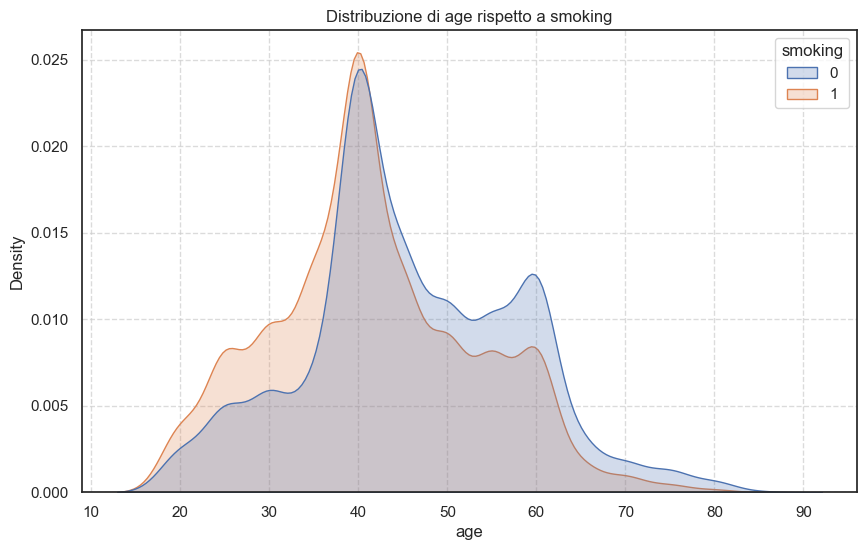

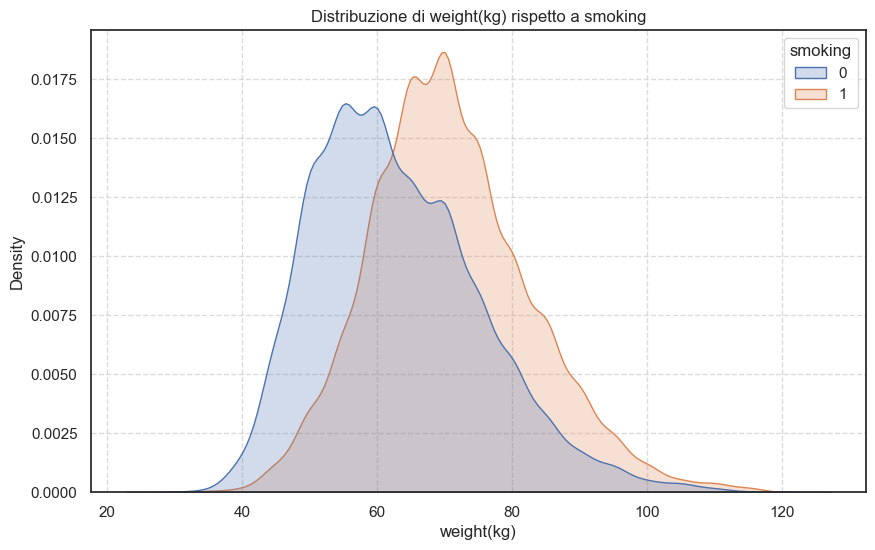

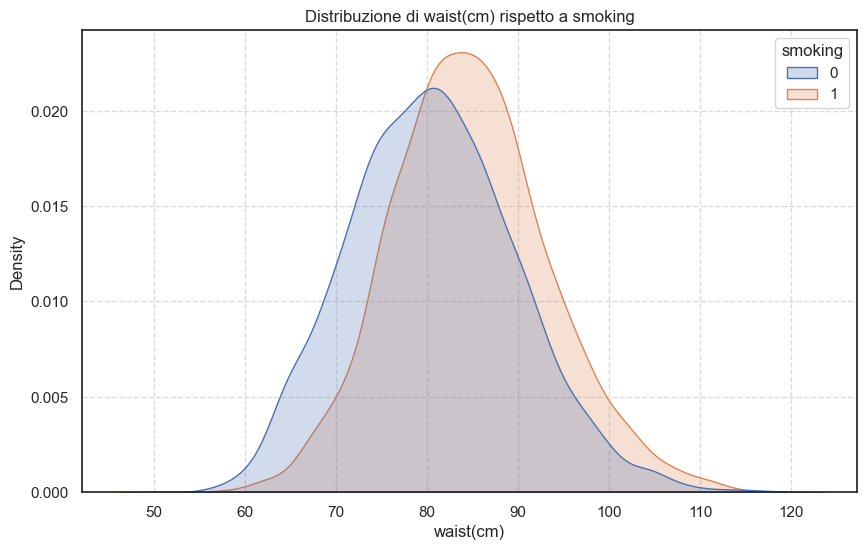

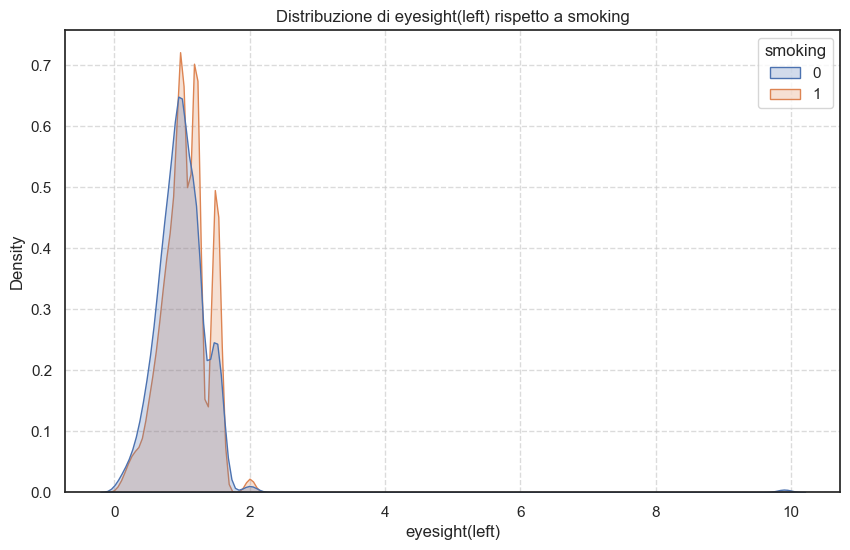

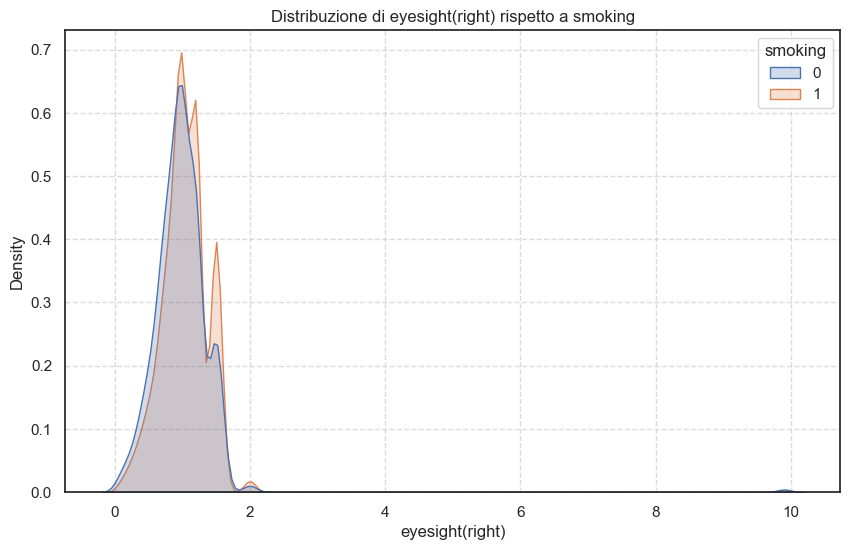

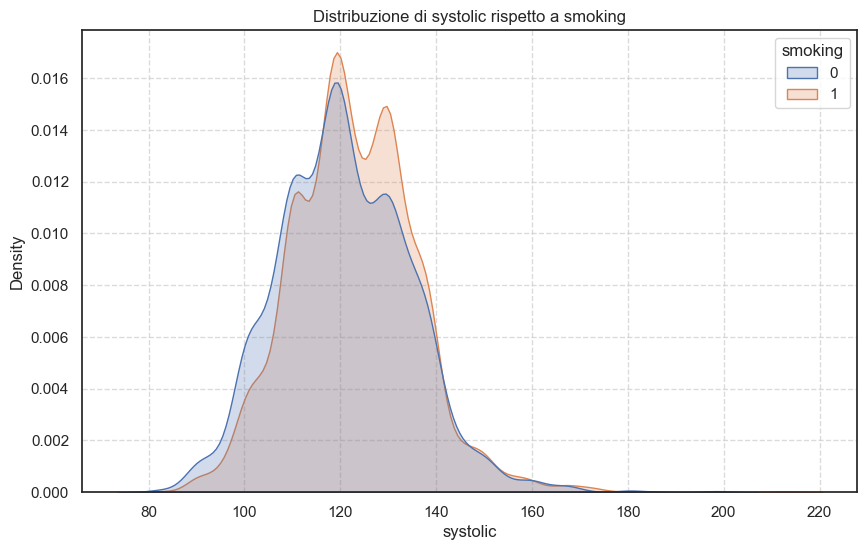

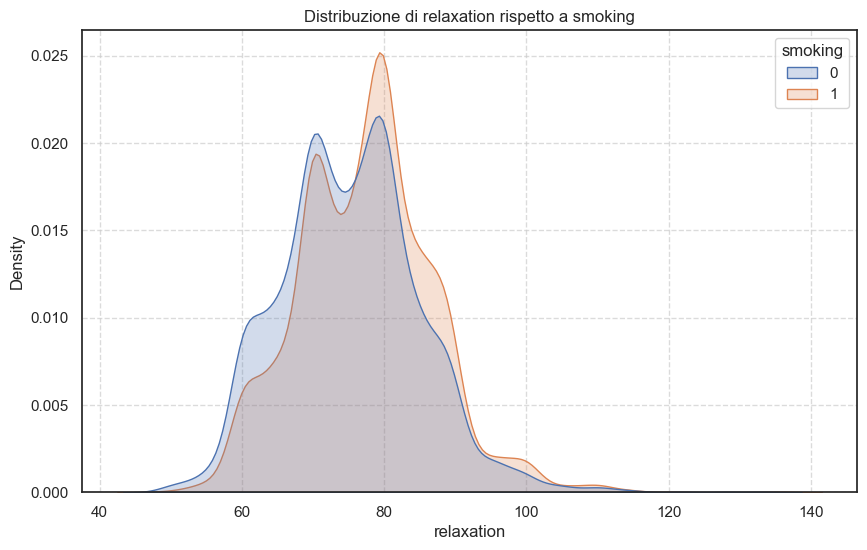

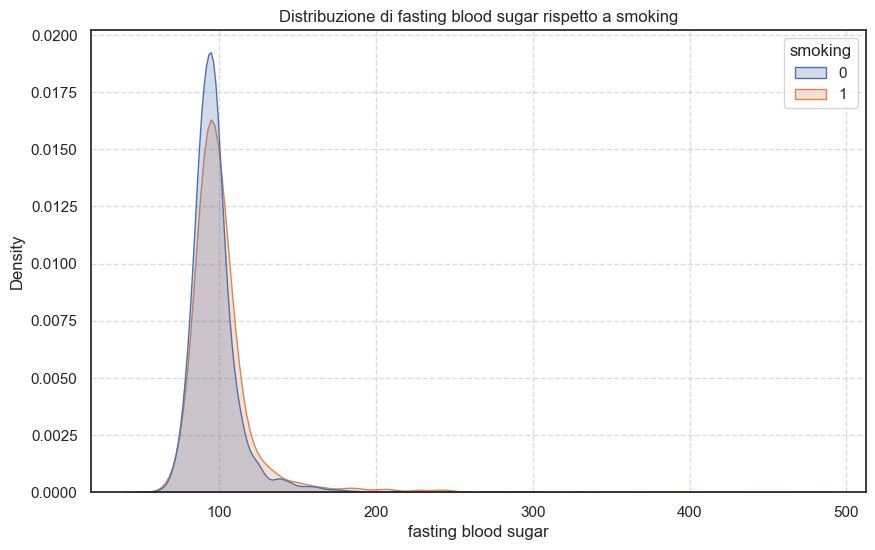

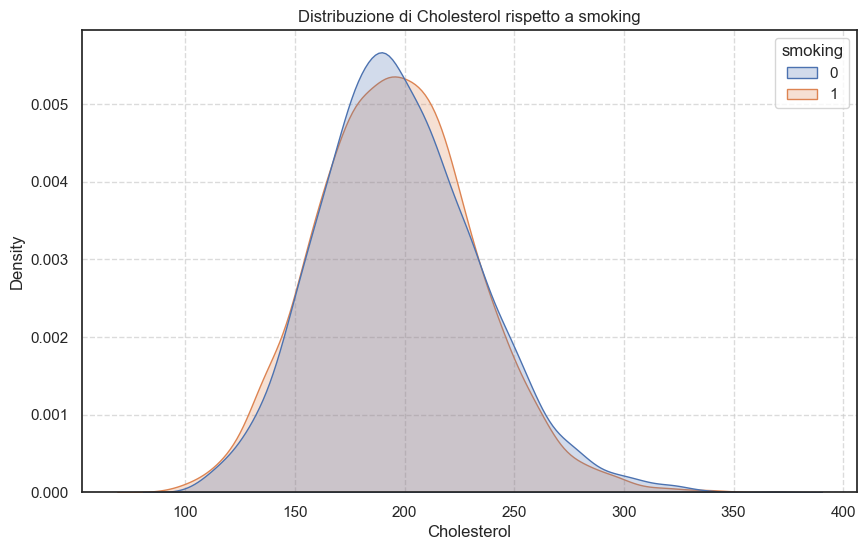

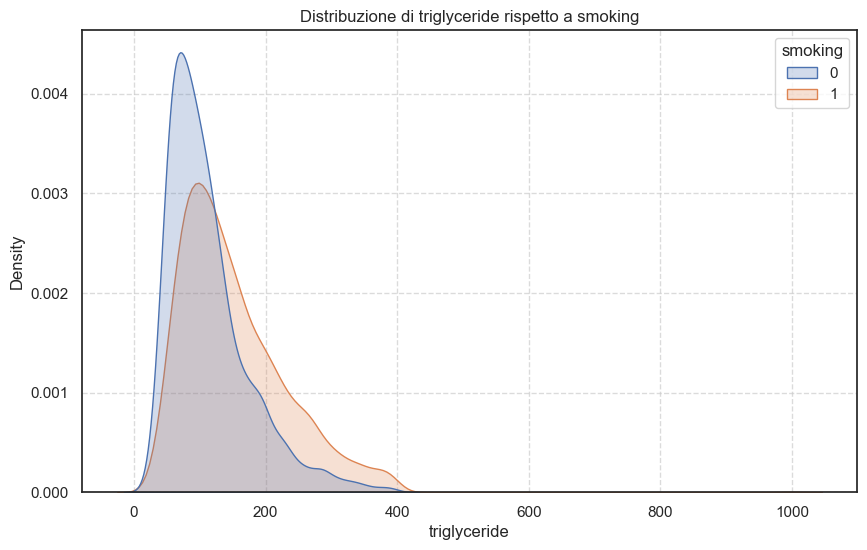

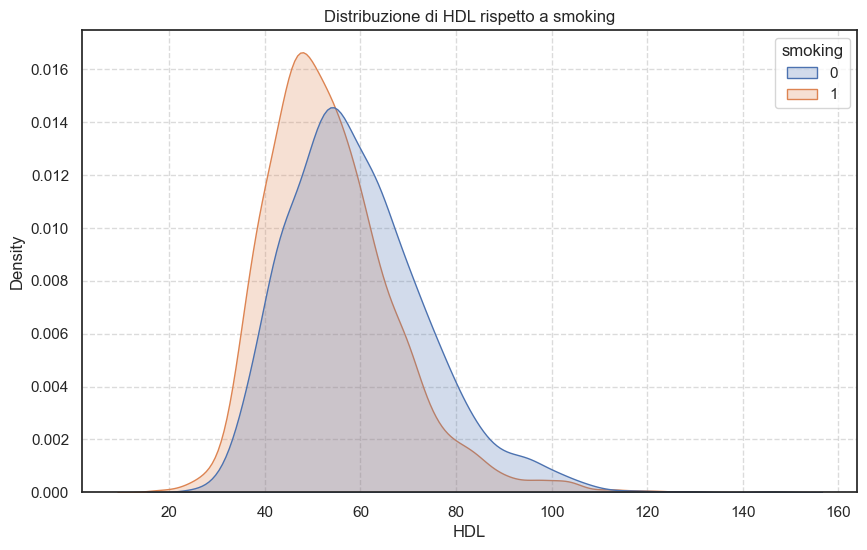

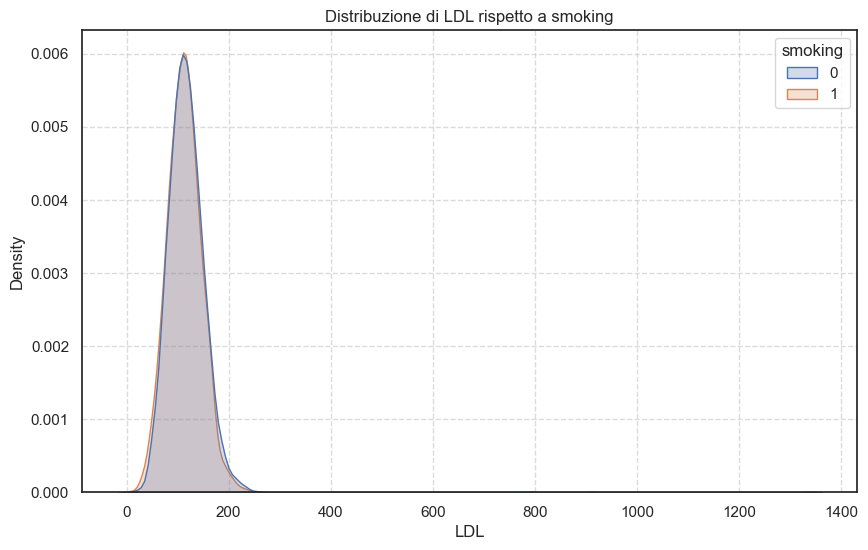

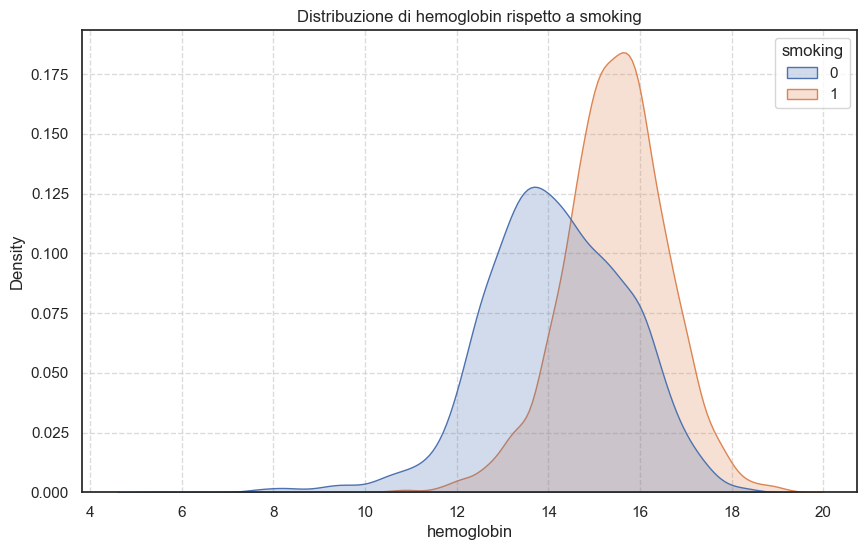

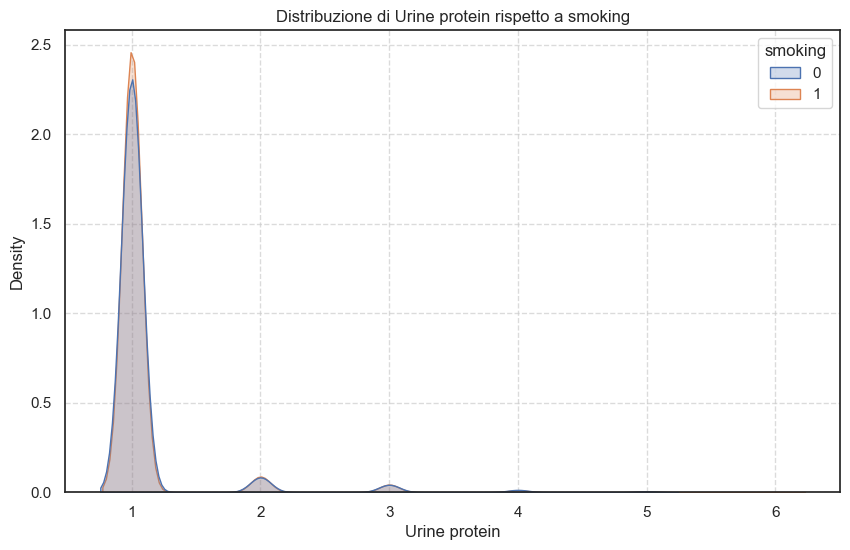

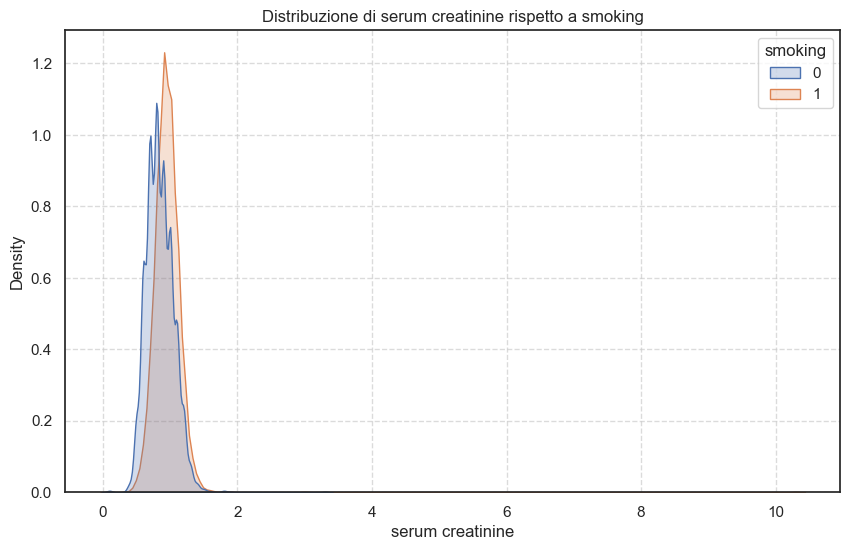

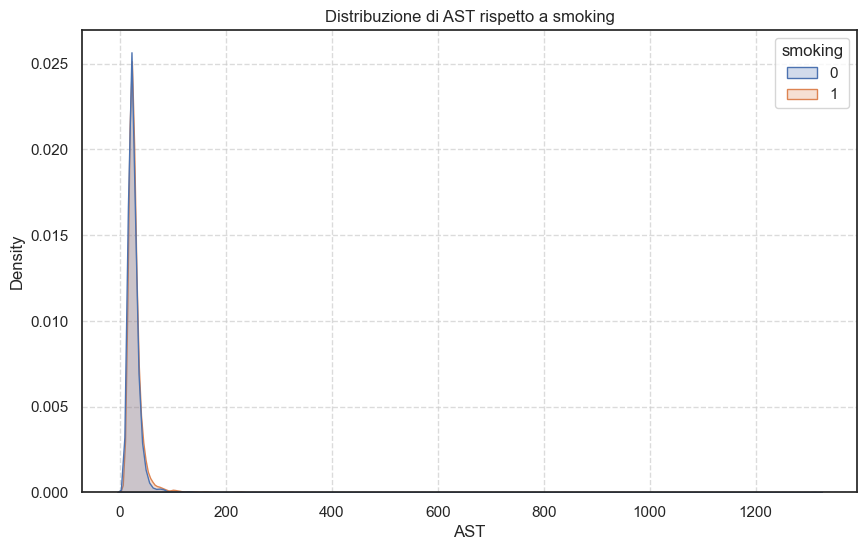

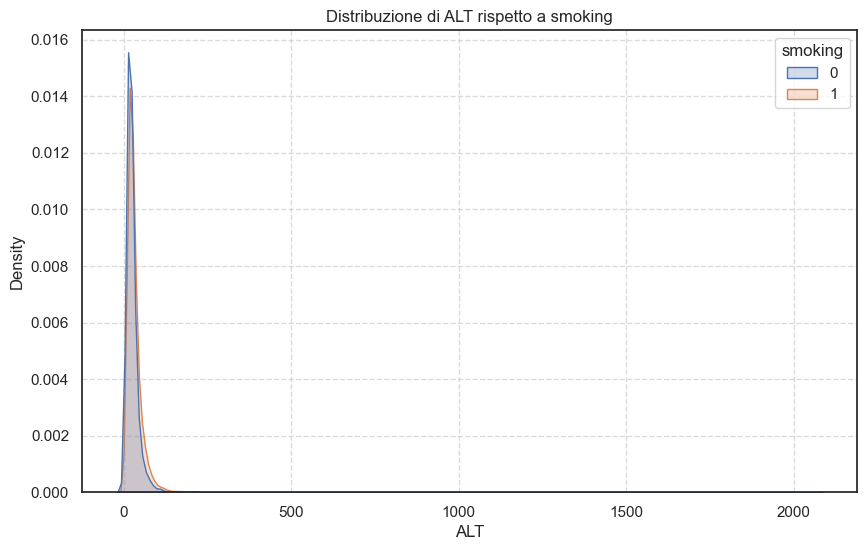

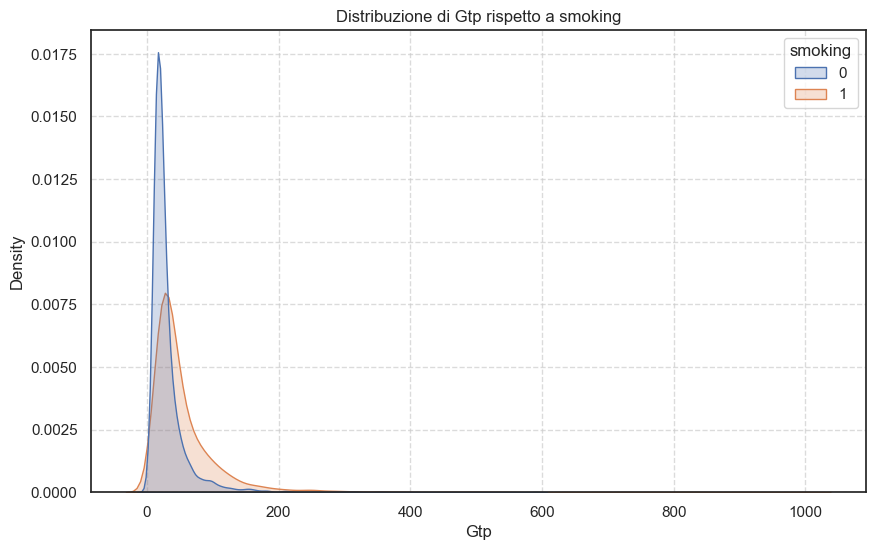

In [75]:

import matplotlib.pyplot as plt
import seaborn as sns

for colonna in variabili_continue:
    plt.figure(figsize=(10, 6))

    # Imposta lo sfondo bianco
    ax = plt.gca()
    ax.set_facecolor('white')

    # Aggiungi la griglia
    ax.grid(True, linestyle='--', alpha=0.7)

    sns.kdeplot(data=df_filtered, x=colonna, hue='smoking', fill=True)
    plt.title(f'Distribuzione di {colonna} rispetto a smoking')
    plt.show()

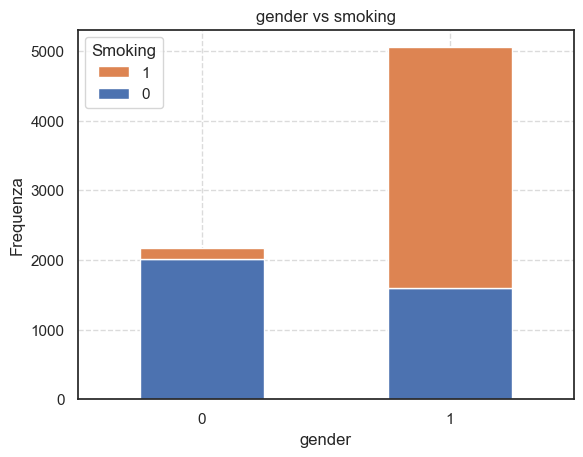

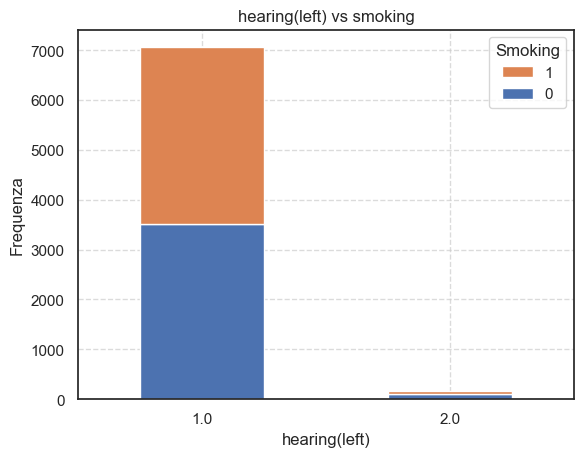

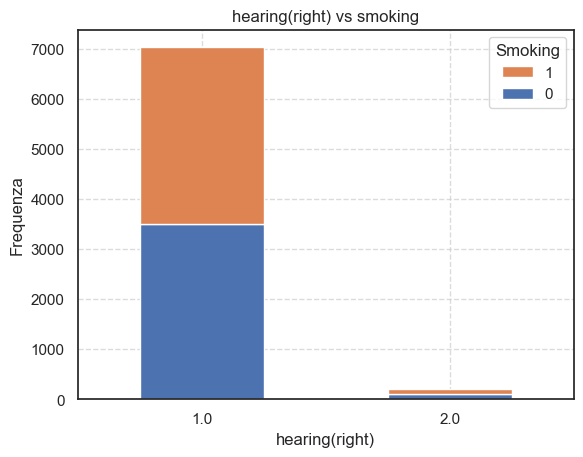

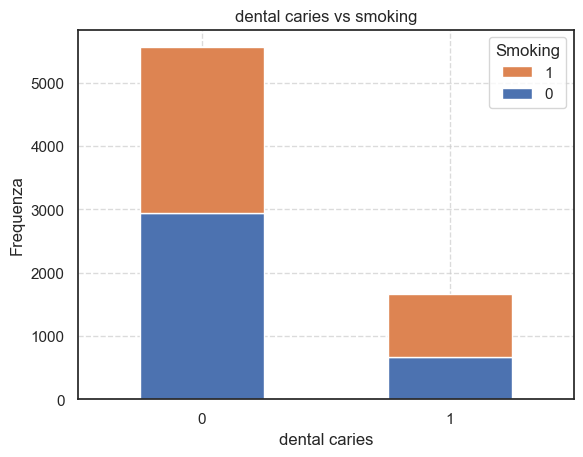

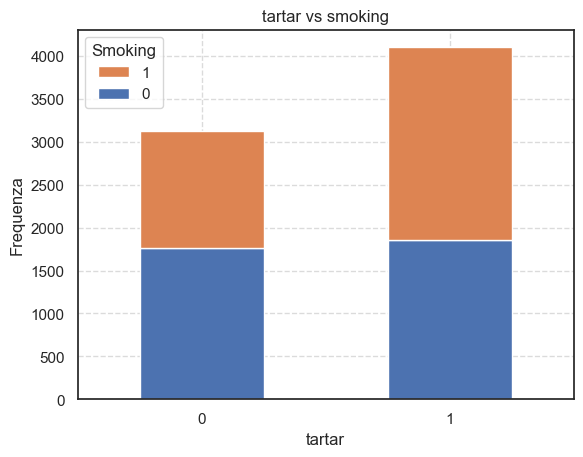

In [76]:
for variabile in variabili_discrete:
    grouped = df_filtered.groupby([variabile, 'smoking']).size().unstack()

    # Creiamo il grafico a barre stackato
    ax = grouped.plot(kind='bar', stacked=True)

    ax.set_facecolor('white')
    ax.grid(True, linestyle='--', alpha=0.7)

    ax.set_title(f'{variabile} vs smoking')
    ax.set_xlabel(f'{variabile}')
    ax.set_ylabel('Frequenza')

    # Rotazione delle labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Aggiungiamo una legenda
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Smoking')

    plt.show()

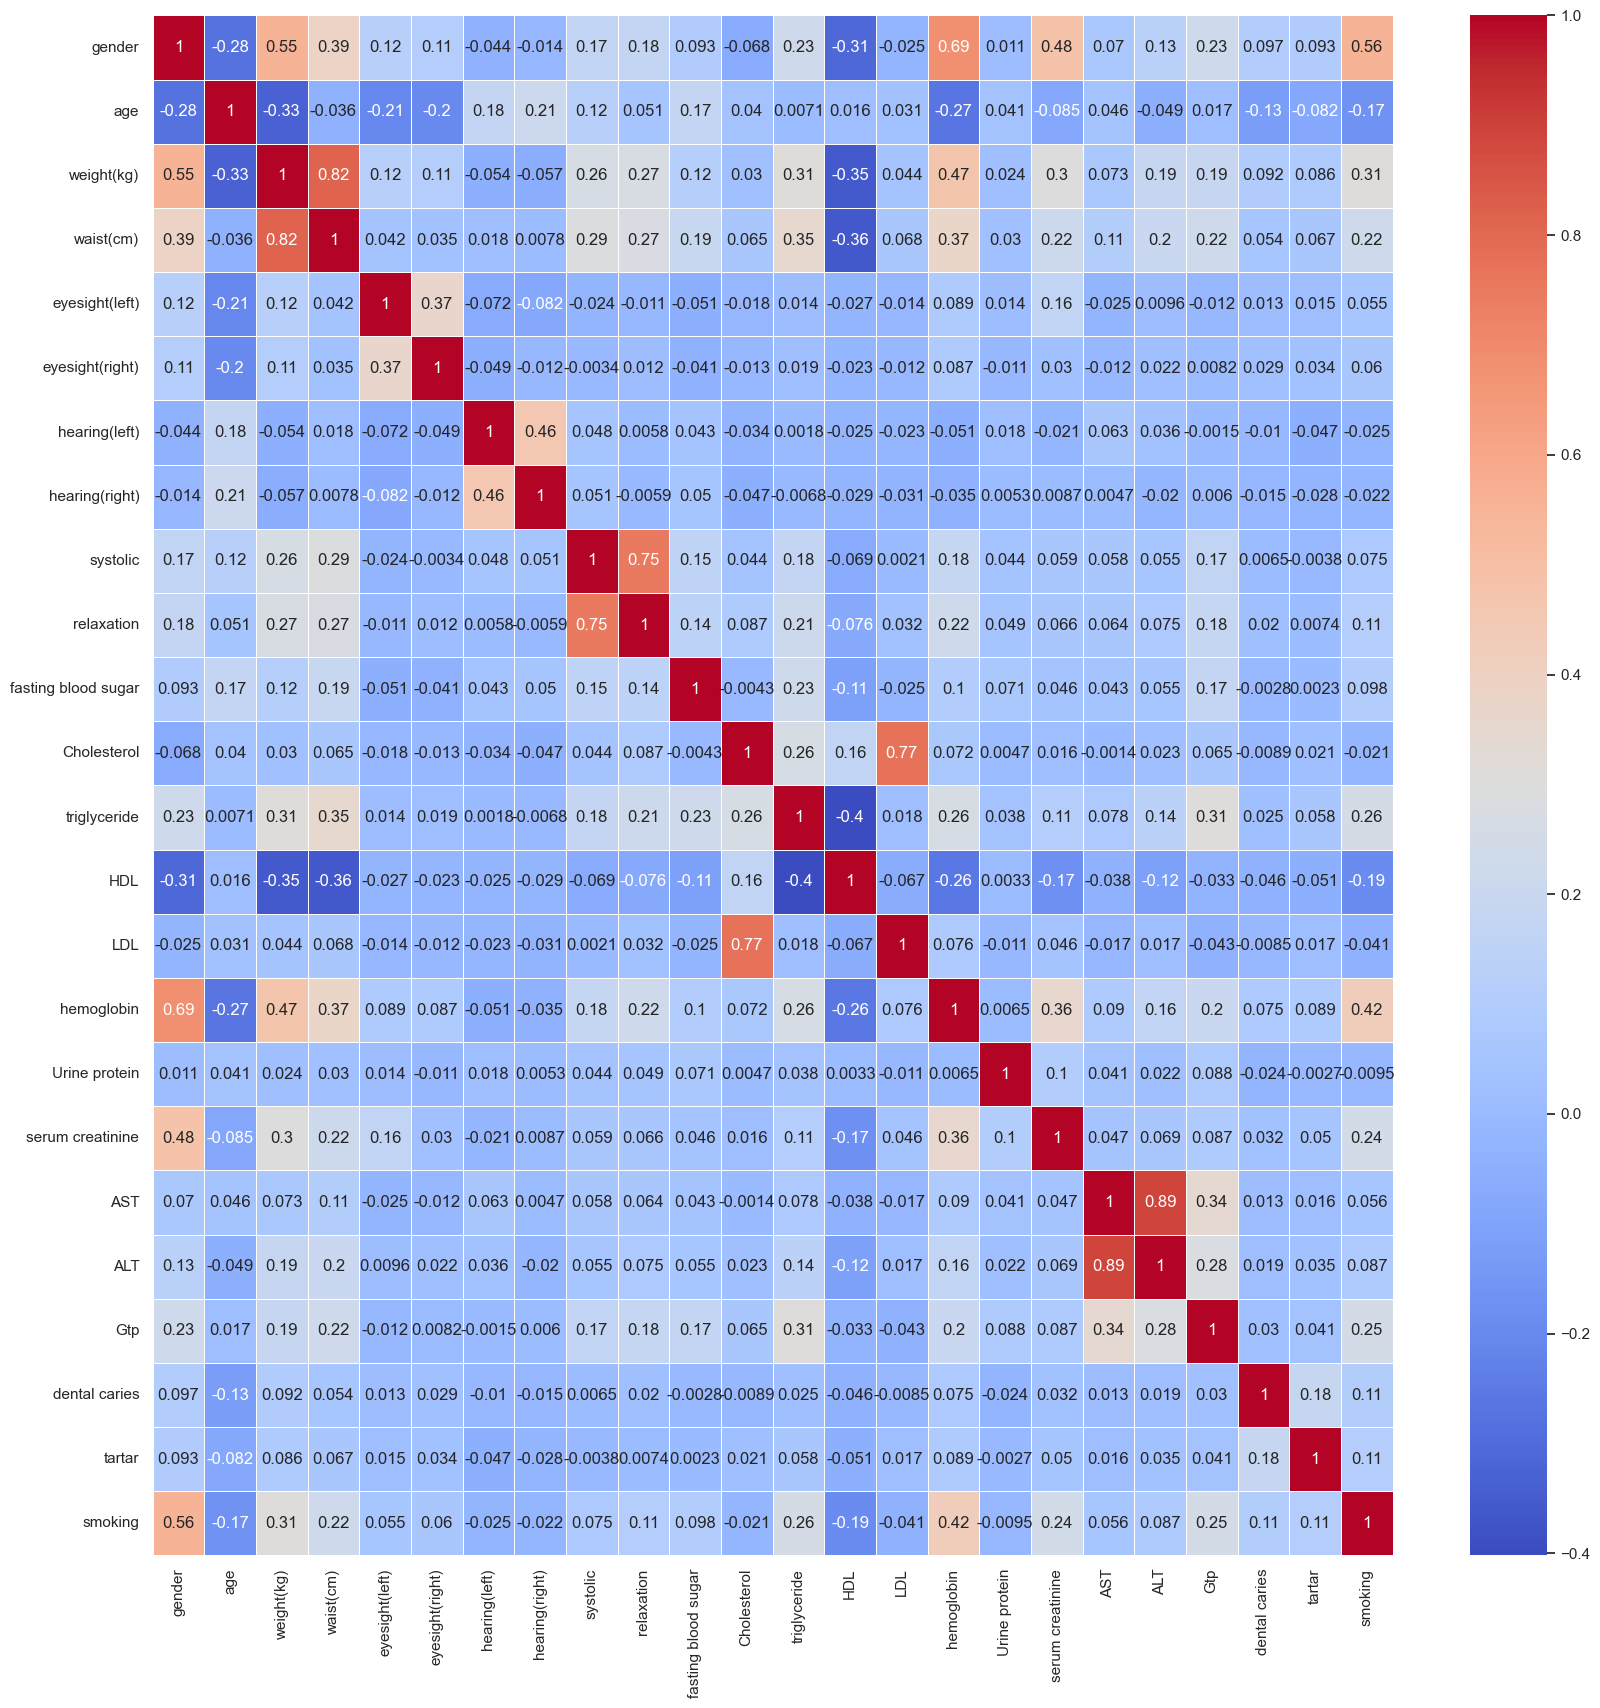

In [77]:
# Calcolare la matrice di correlazione
correlation_matrix = df_filtered.corr()

# Creare una heatmap utilizzando seaborn
sns.set(style="white")  # Impostare uno stile per il background
plt.figure(figsize=(20, 20))  # Impostare le dimensioni della figura

# Creare la heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

# Visualizzare la heatmap
plt.show()

In [78]:
from sklearn.model_selection import train_test_split

# Supponiamo che 'df' sia il tuo DataFrame e 'target_column' sia la colonna da predire
# Sostituisci 'df' e 'target_column' con i tuoi dati effettivi
X = df_filtered.drop('smoking', axis=1)
y = df_filtered['smoking']

# Suddividi il dataset in set di addestramento e test (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ora puoi utilizzare X_train, X_test, y_train, y_test per addestrare e valutare il tuo modello


In [79]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Fai le predizioni sul set di test
y_true = np.ones(len(y_test))
y_pred = np.ones(len(y_test))

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Stampa la matrice di confusione
print("Matrice di Confusione:")
print(cm)

Matrice di Confusione:
[[   0 1087]
 [   0 1083]]


In [80]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(model, filled=True, ax=ax)
plt.plot()

[]

In [81]:
# predizione del nuovo modello
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm)
print("\nAccuracy:", cm.diagonal().sum() / cm.sum())

Confusion matrix:
 [[757 330]
 [323 760]]

Accuracy: 0.6990783410138249


In [82]:
# andiamo a lavorare sul parametro di complessità, che stima il vantaggio di aggiungere/togliere degli split
# in funzione degli errori di classificazione
# più il modello è complesso e più viene penalizzato
path = model.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas

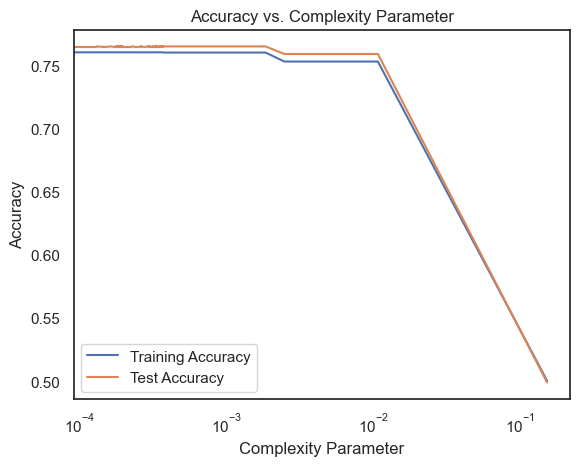

In [83]:
# valori di complessità candidati ad essere tagliati dal modello
# complexity_values = [0.001, 0.01, 0.1, 1, 10, 100]
ccp_alphas = path.ccp_alphas

# Addestra l'albero decisionale con diversi valori di complessità
train_accuracy = []
test_accuracy = []
for complexity in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=3, ccp_alpha=complexity)
    clf.fit(X_train, y_train)
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

# Plotta l'accuratezza del modello in funzione del parametro di complessità
plt.plot(ccp_alphas, train_accuracy, label='Training Accuracy')
plt.plot(ccp_alphas, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [101]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    print(
        "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
            clfs[-1].tree_.node_count, ccp_alphas[-1]
        )
)

Number of nodes in the last tree is: 1575 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1569 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1563 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1547 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1543 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1539 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1531 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1531 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1519 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1519 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1519 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1507 with ccp_alpha: 0.15355144375597063
Number of nodes in the last tree is: 1507 with ccp_alpha: 0.1535

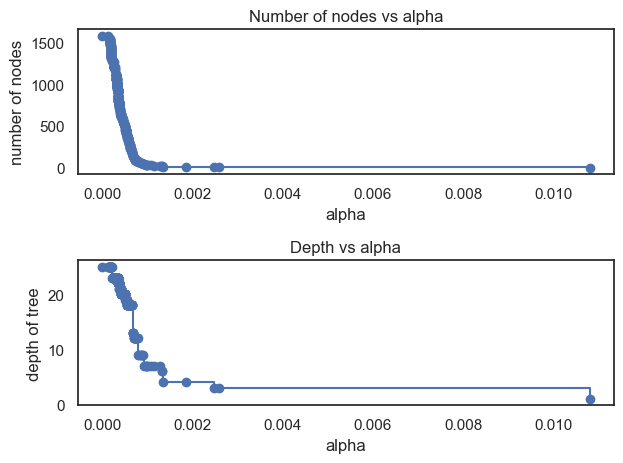

In [85]:
clfs = clfs[:-1]
complexity_values = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(complexity_values, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(complexity_values, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

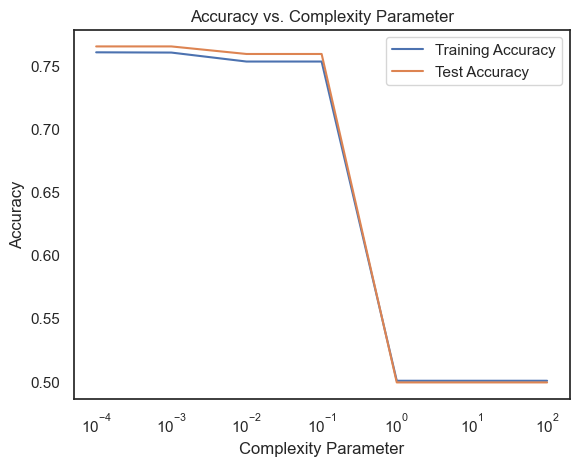

In [103]:
complexity_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

train_accuracy = []
test_accuracy = []
for complexity in complexity_values:
    clf = DecisionTreeClassifier(max_depth=3, ccp_alpha=complexity)
    clf.fit(X_train, y_train)
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))


plt.plot(complexity_values, train_accuracy, label='Training Accuracy')
plt.plot(complexity_values, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [117]:
from sklearn.metrics import accuracy_score

clf_pruned = DecisionTreeClassifier(max_depth=3, ccp_alpha=0.001)
clf_pruned.fit(X_train, y_train)


accuracy_pruned = clf_pruned.score(X_test, y_test)
print(accuracy_pruned)

0.7654377880184332


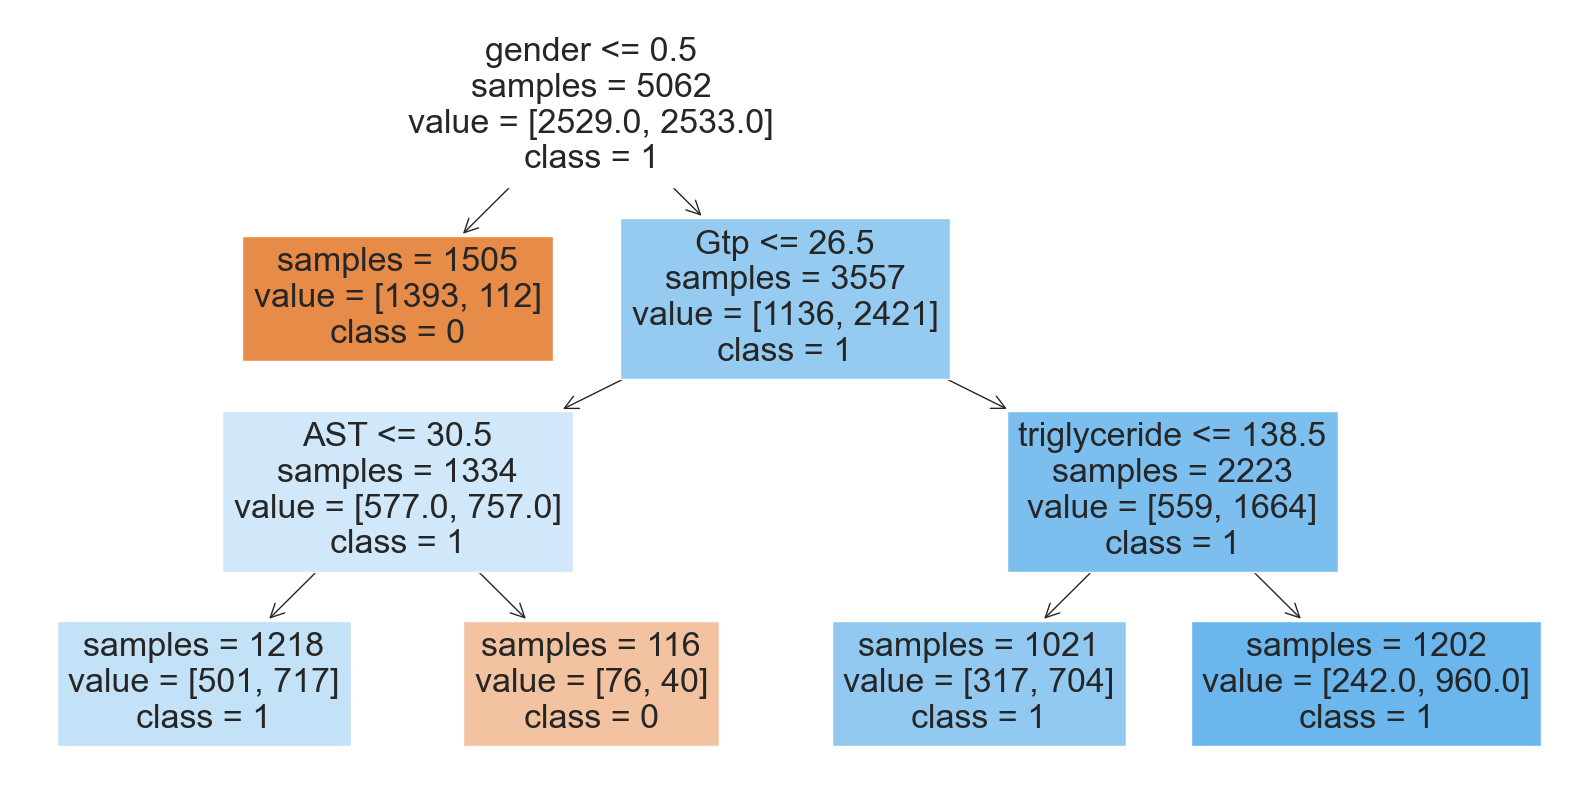

Confusion matrix:
 [[ 647  440]
 [  69 1014]]

Accuracy: 0.7654377880184332


In [118]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(clf_pruned,
          feature_names=X_train.columns,
          class_names=[str(x) for x in clf_pruned.classes_],
          filled=True,
          ax=ax,
          impurity=False)

plt.show()
from sklearn.metrics import confusion_matrix

y_pred = clf_pruned.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm)
print("\nAccuracy:", cm.diagonal().sum() / cm.sum())